# Analysis of Wall Street Bets Subreddit vs Meme Stock Prices
## Team: TheDAO
### Members:
- Colin Chan Wei Hua        A0199771J
- Leu Pei Lin Denise        A0221004H
- Png Zheng Jie, Sebastian  A0201782L
- Yak Jun Yan James         A0218097X
- Yeoh An Ni                A0225614L

## Importing Relevant Libraries

In [ ]:
import datetime
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from emoji import get_emoji_regexp
from functools import reduce
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

## 1. Data wrangling
Performed data wrangling of reddit dataset by converting timestamps into dates and removing emojis, punctuations, tags, links, NaN values and empty strings.

In [1]:
# Import data
reddit = pd.read_csv('./Datasets/reddit_wsb.csv')
# amc_price = pd.read_csv('./Datasets/AMC Historical Data.csv')
# bb_price = pd.read_csv('./Datasets/BB Historical Data.csv')
# clov_price = pd.read_csv('./Datasets/CLOV Historical Data.csv')
# gme_price = pd.read_csv('./Datasets/GME Historical Data.csv')

# Merging meme stock data


# Data wrangling of Reddit data
# Data cleaning functions
emoji_pattern = get_emoji_regexp()

def remove_emojis(text):
    return re.sub(emoji_pattern, '', text)

def remove_punctuations(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def remove_tags(text):
    return re.sub('@[\w]*', '', text)

def remove_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

# Applies a list of functions to a dataframe and returns the resultant dataframe
def data_cleaning(df, func_list):
    result = df.copy()
    for f in func_list:
        result = result.apply(f)
    return result

# List of data cleaning functions
cleaning_func = [(lambda x : remove_emojis(x)), (lambda x: x.lower()), (lambda x: remove_URLs(x)), 
                 (lambda x: remove_tags(x)), (lambda x: remove_punctuations(x)), (lambda x: x.strip())]

# Change Timestamp to date format
reddit['timestamp'] = pd.to_datetime(reddit['timestamp']).dt.date
reddit.rename(columns = {'timestamp': 'date'}, inplace = True)

# Removes any rows with dates outside of 2021
reddit = reddit[reddit['date'] >= datetime.date(2021, 1, 1)]

# Extract out relevant data - the date, thread title and body only
reddit_body = reddit[['date', 'body']].copy()

# Data Cleaning
reddit_body = reddit_body[reddit_body['body'].notna()] # removes NaN values
reddit_body['body'] = data_cleaning(reddit_body['body'], cleaning_func)

# Removes rows with empty strings
reddit_body = reddit_body[reddit_body['body'] != '']

# Resets row index
reddit_body = reddit_body.reset_index(drop = True)

reddit_body.head()

,date,body
0,2021-01-28,the ceo of nasdaq pushed to halt trading to gi...
1,2021-01-28,hedgefund whales are spreading disinfo saying ...
2,2021-01-28,life isnt fair my mother always told me that w...
3,2021-01-28,i believe right now is one of those rare oppor...
4,2021-01-28,you guys are champs gme who would have thought...


## 2. Wordcloud of Top 100 Words in WSB Thread Bodies.

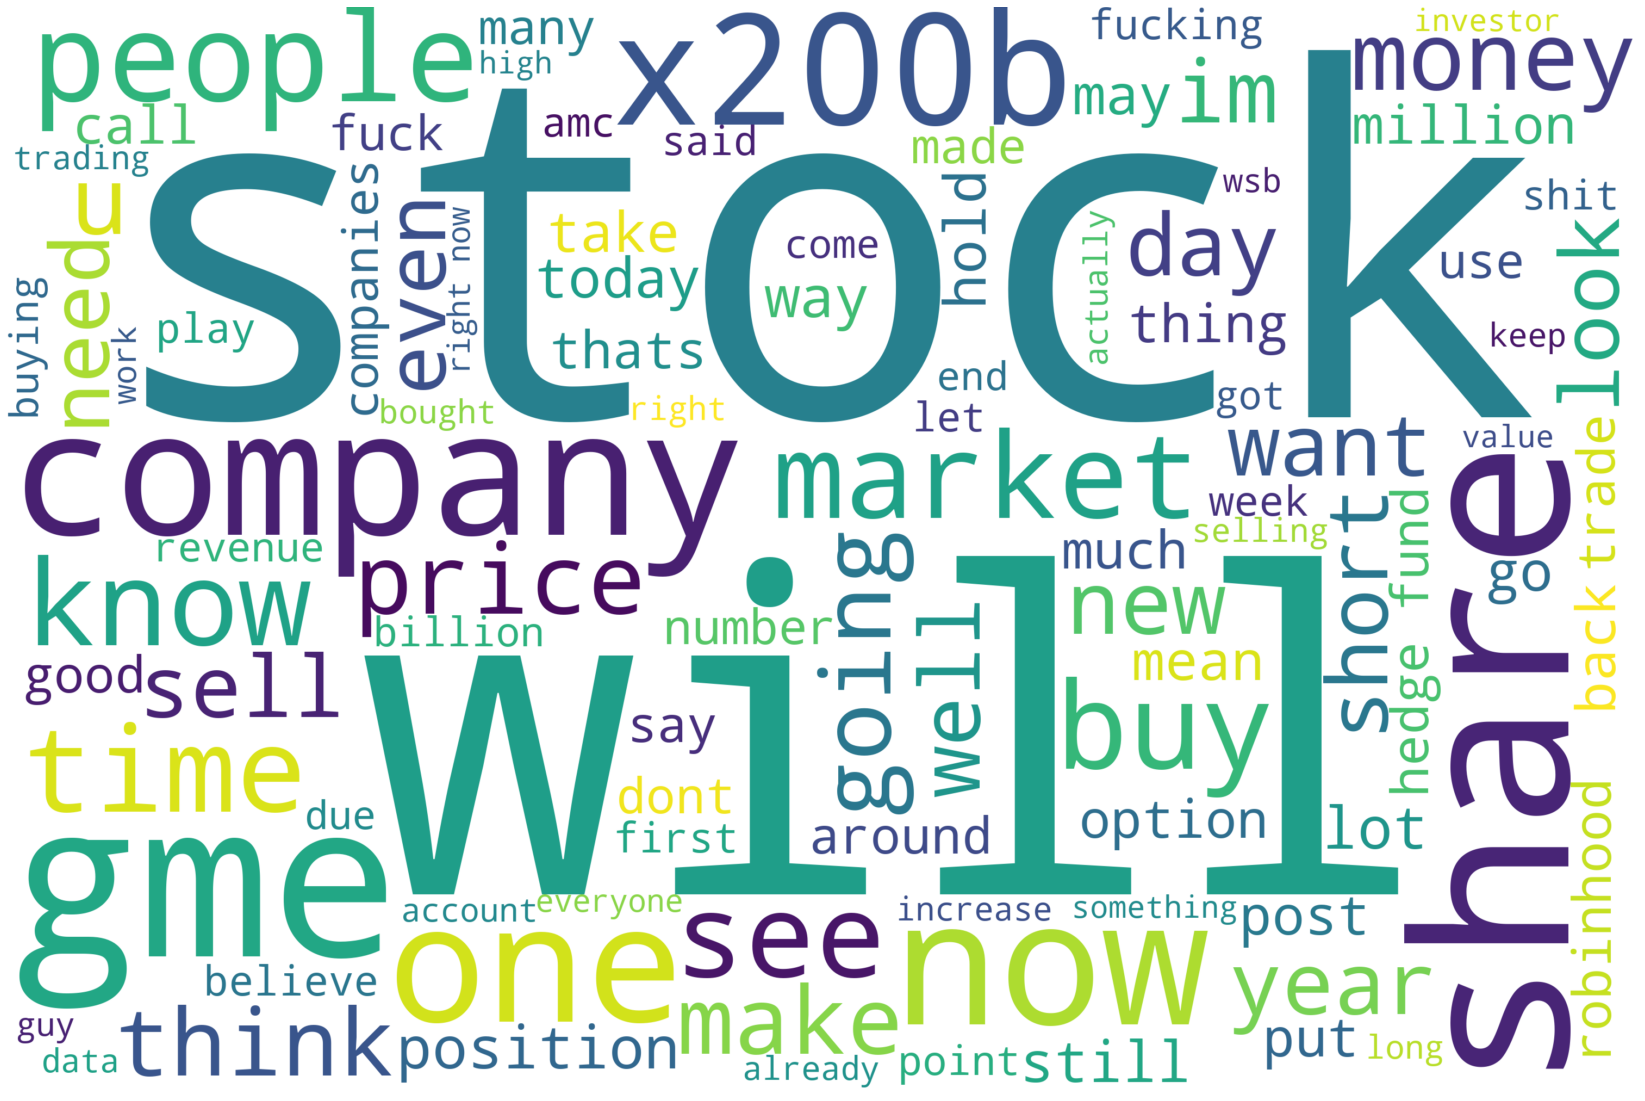

In [2]:
def createWordCloud(text):
    # Generates a word cloud image
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                          max_words = 100, stopwords = STOPWORDS).generate(text)

    # Displays the wordcloud image
    plt.figure(figsize = (30,20))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

# Combining bodies of all threads 
body_text = ' '.join(body for body in reddit_body['body'])

# Create word cloud from all thread bodies
createWordCloud(body_text)

## 3.Top 30 Words in the WSB Thread Bodies

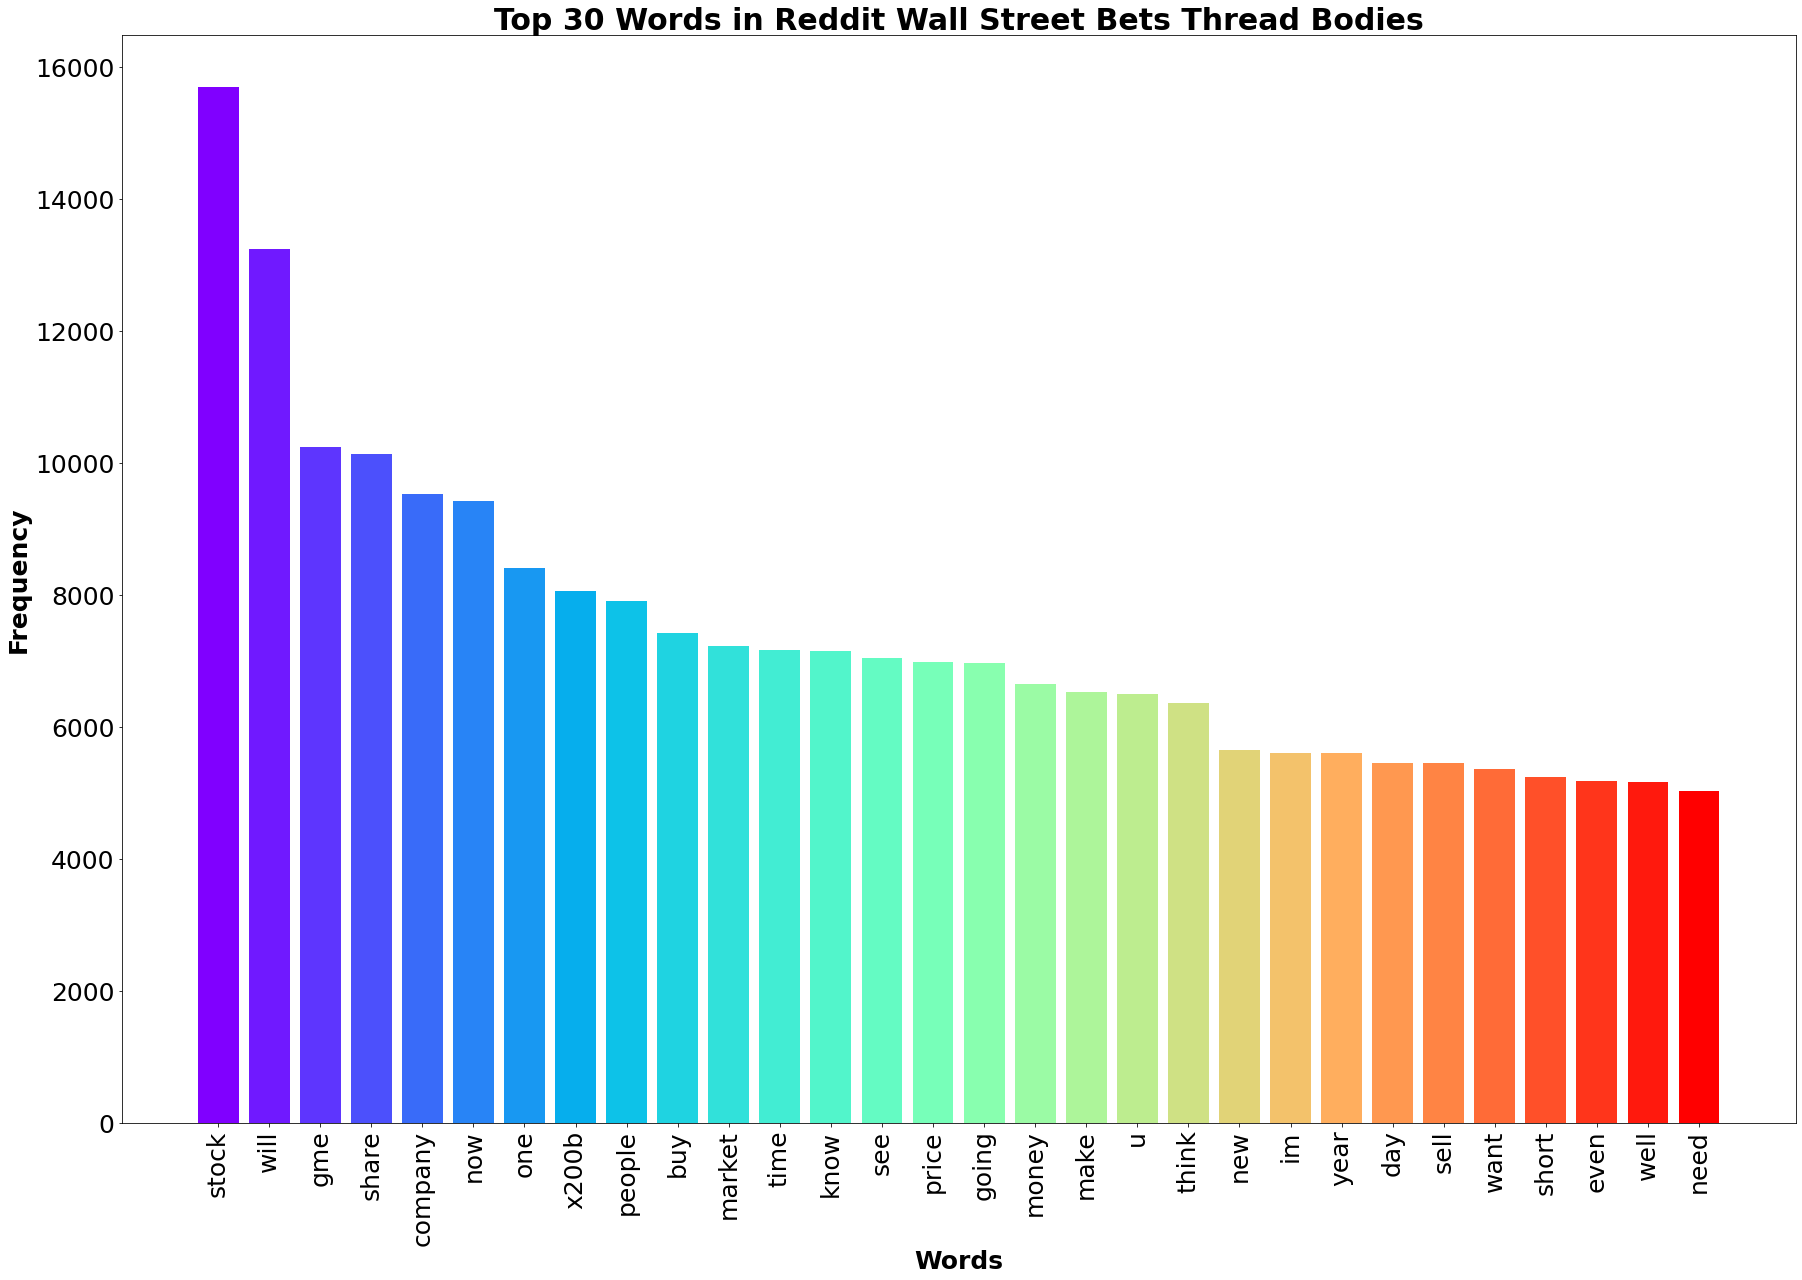

In [3]:
# Process all thread bodies into a dictionary of words to frequency
body_word_to_freq = WordCloud(stopwords = STOPWORDS).process_text(body_text)

# Get top 30 words by their frequency
body_word_to_freq_top30 = dict(sorted(body_word_to_freq.items(), key = lambda item: item[1], reverse = True)[:30])

# Plot bar chart of top 30 words
plt.figure(figsize = (30,20))
plt.bar(*zip(*body_word_to_freq_top30.items()), color = plt.cm.rainbow(np.linspace(0, 1, 30)))
plt.title("Top 30 Words in Reddit Wall Street Bets Thread Bodies", fontsize = 30, fontweight = "bold")
plt.xticks(fontsize = 25, rotation = 90)
plt.yticks(fontsize = 25)
plt.xlabel("Words", fontsize = 25, fontweight = "bold")
plt.ylabel("Frequency", fontsize = 25, fontweight = "bold")
plt.show()

## 4. Sentiment Analysis of Thread Bodies
Sentiment Analysis is conducted using the VADER (Valence Aware Dictionary for Sentiment Reasoner) Sentiment Analysis (VSA). VSA assigns each word or phrase a score and combines all individual segments in a sentence to give four scores: positive, neutral, negative, and compound. The scores for each component indicate the strength of their respective directions, while the compound score is the normalized overall score for the input

In [4]:
# Conducting sentiment analysis using VADER model 
sia = SentimentIntensityAnalyzer()

def addSentimentAnalysis(df, columnName):
    # Creates new column in the input dataframe
    columns = {col: 0 for col in ['negative', 'neutral', 'positive', 'compound', 'sentiment']}
    df.assign(**columns)
    
    for i in range(len(df.index)):
        sentence = df[columnName][i]
        scores = sia.polarity_scores(sentence)

        df.loc[i, 'negative'] = scores.get('neg')
        df.loc[i, 'positive'] = scores.get('pos')
        df.loc[i, 'neutral'] = scores.get('neu')
        df.loc[i, 'compound'] = scores.get('compound')

        if scores.get('compound') > 0: 
            df.loc[i, 'sentiment'] = 1
        elif scores.get('compound') == 0: 
            df.loc[i, 'sentiment'] = 0
        else: 
            df.loc[i, 'sentiment'] = -1

addSentimentAnalysis(reddit_body, 'body')
reddit_body.head()

,date,body,negative,positive,neutral,compound,sentiment
0,2021-01-28,the ceo of nasdaq pushed to halt trading to gi...,0.054,0.084,0.862,0.7854,1.0
1,2021-01-28,hedgefund whales are spreading disinfo saying ...,0.000,0.056,0.944,0.7784,1.0
2,2021-01-28,life isnt fair my mother always told me that w...,0.172,0.068,0.760,-0.9927,-1.0
3,2021-01-28,i believe right now is one of those rare oppor...,0.082,0.153,0.765,0.8271,1.0
4,2021-01-28,you guys are champs gme who would have thought...,0.068,0.120,0.812,0.9384,1.0


The sentiments are then grouped by dates, filtered by individual stocks (GME, AMC, BB, CLOV) and combined into a single dataframe that is exported as a csv file.

In [6]:
# Creates a dataframe with average sentiments grouped by dates
def filter_df(df, columnName, strToFilter):
    suffix = re.sub('\|.+', '', strToFilter)
    rdf = (df[df[columnName].str.contains(r'\b{0}\b'.format(strToFilter))].groupby('date')
                                                                          .agg({'negative': ['count', ('negative_mean', 'mean')],
                                                                                'positive': [('positive_mean', 'mean')],
                                                                                'neutral': [('neutral_mean', 'mean')],
                                                                                'compound': [('compound_mean', 'mean')]})
                                                                          .add_suffix('_body' + ('' if not suffix else '_' + suffix))
                                                                          .reset_index())
    
    rdf.columns = rdf.columns.droplevel(0)
    rdf = rdf.rename(columns = {'':'date'})
    return (rdf)

# Strings to filter the dataframe
amc_words = 'amc'
bb_words = 'bb|blackberry|black berry'
clov_words = 'clov|clover'
gme_words = 'gme|gamestop|game stop|gamestonks'

# Filtering dataframe by individual stock ticker symbols
amc_body = filter_df(reddit_body, 'body', amc_words)
bb_body = filter_df(reddit_body, 'body', bb_words)
clov_body = filter_df(reddit_body, 'body', clov_words)
gme_body = filter_df(reddit_body, 'body', gme_words)

# Main dataframes
reddit_body_daily = filter_df(reddit_body, 'body', '')

# Merging all dataframes
dfs = [reddit_body_daily, gme_body, amc_body, bb_body, clov_body]
reddit_wsb_daily = reduce(lambda df1, df2: pd.merge(df1, df2, on = 'date', how = 'left'), dfs)

# Export daily aggregated data to csv
reddit_wsb_daily.to_csv("./Datasets/reddit_wsb_daily.csv", index = False)

reddit_wsb_daily.head()

,date,count_body,negative_mean_body,positive_mean_body,neutral_mean_body,compound_mean_body,count_body_gme,negative_mean_body_gme,positive_mean_body_gme,neutral_mean_body_gme,...,count_body_bb,negative_mean_body_bb,positive_mean_body_bb,neutral_mean_body_bb,compound_mean_body_bb,count_body_clov,negative_mean_body_clov,positive_mean_body_clov,neutral_mean_body_clov,compound_mean_body_clov
0,2021-01-28,684,0.089819,0.095503,0.813212,0.049073,255.0,0.083588,0.087827,0.828584,...,63.0,0.081778,0.083810,0.834476,0.024211,NaN,NaN,NaN,NaN,NaN
1,2021-01-29,9034,0.089565,0.093308,0.816350,0.005164,2507.0,0.083899,0.093570,0.822520,...,623.0,0.080437,0.087231,0.832313,0.020259,NaN,NaN,NaN,NaN,NaN
2,2021-01-30,648,0.081015,0.115835,0.803154,0.249954,363.0,0.081085,0.114570,0.804342,...,49.0,0.083633,0.101612,0.814816,0.335365,NaN,NaN,NaN,NaN,NaN
3,2021-01-31,426,0.087824,0.115261,0.796904,0.241274,279.0,0.086867,0.118430,0.794692,...,37.0,0.085351,0.107946,0.806676,0.056441,NaN,NaN,NaN,NaN,NaN
4,2021-02-01,319,0.075276,0.114342,0.810364,0.379849,215.0,0.077423,0.112377,0.810186,...,34.0,0.072118,0.107500,0.820441,0.508288,NaN,NaN,NaN,NaN,NaN


## 5.  Average Sentiments vs Meme Stock Prices

## 6. Proportion of Threads vs Meme Stock Prices 

## 7. Mean Compound Sentiments Across Meme Stocks

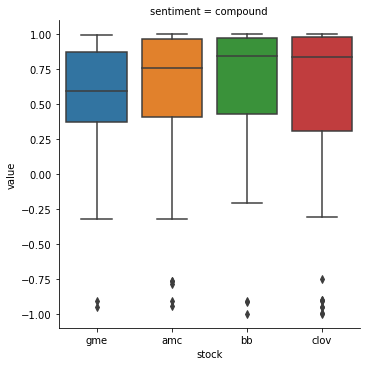

In [35]:
# Get mean thread body compound sentiment of individual stocks
compound = reddit_wsb_daily.iloc[:, np.r_[10, 15, 20, 25]]

# Convert dataframe from wide to long format
compound_long = compound.melt(var_name = 'sentiment')

# Add column to identify stock
compound_long['stock'] = compound_long['sentiment'].apply(lambda x: re.sub('.+_mean_body_', '', x))

# Clean sentiment column
compound_long['sentiment'] = compound_long['sentiment'].apply(lambda x: re.sub('_.+', '', x))

# Drop NaN rows
compound_long = compound_long.dropna(subset = ['value'])

# Plot catplot
sns.catplot(data = compound_long, x = 'stock', y = 'value', col = 'sentiment', kind = 'box', col_wrap = 1)

## 8. Correlation between Average Sentiment of all WSB Threads vs respective Stock Prices

## 9. Proportion of WSB Thread Bodies by Meme Stock

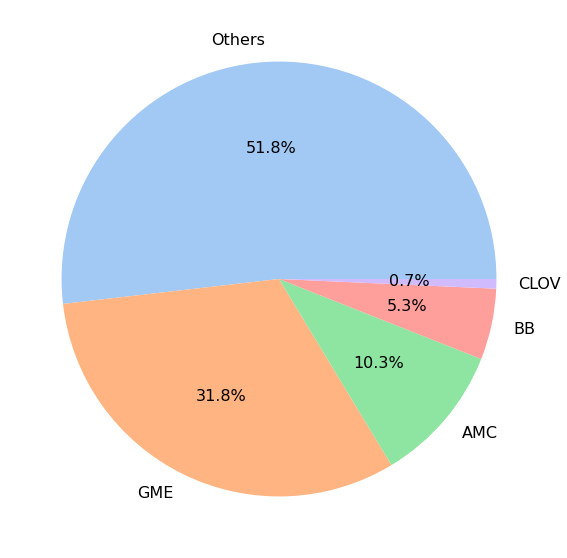

In [37]:
# Get overall count of columns
overall_count = reddit_wsb_daily[['count_body', 'count_body_gme', 'count_body_amc', 'count_body_bb', 'count_body_clov']].sum(axis = 0)

# Get remaining count of non-individual stocks
overall_count[0] -= sum(overall_count[1:5])

# Rename indices
overall_count.rename(index = {'count_body':'Others', 'count_body_gme':'GME', 'count_body_amc':'AMC', 'count_body_bb':'BB',
                              'count_body_clov':'CLOV'}, inplace = True)

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Plot pie chart
plt.figure(figsize = (15,10))
plt.pie(overall_count, labels = overall_count.index, colors = colors, autopct='%1.1f%%', textprops = {'fontsize': 16})
plt.show()